<a href="https://colab.research.google.com/github/plaban1981/MachineHack-1/blob/master/Machine_hack_housing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

     |████████████████████████████████| 66.2MB 57kB/s 


**bayesian-optimization**

In [2]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=6eeeede1a63472b5691493690c169f703ef2bcb37e453e93cfe74c7210dc8826
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
pip install geopy

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

In [5]:
!unzip "/content/drive/My Drive/AV_Hack/Participants_Data_HPP.zip" 

Archive:  /content/drive/My Drive/AV_Hack/Participants_Data_HPP.zip
   creating: Participants_Data_HPP/
  inflating: Participants_Data_HPP/Test.csv  
  inflating: __MACOSX/Participants_Data_HPP/._Test.csv  
  inflating: Participants_Data_HPP/Train.csv  
  inflating: __MACOSX/Participants_Data_HPP/._Train.csv  
  inflating: Participants_Data_HPP/sample_submission.csv  
  inflating: __MACOSX/Participants_Data_HPP/._sample_submission.csv  


In [6]:
#importing files
train = pd.read_csv('/content/Participants_Data_HPP/Train.csv')
test = pd.read_csv('/content/Participants_Data_HPP/Test.csv')

In [ ]:
train.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [ ]:
train["COORDINATES"] = train["LONGITUDE"].astype(str) +"," + train["LATITUDE"].astype(str)

In [ ]:
test["COORDINATES"] = test["LONGITUDE"].astype(str) +"," + test["LATITUDE"].astype(str)

In [ ]:
train.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),COORDINATES
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,"12.96991,77.59796"
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,"12.274538,76.644605"
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,"12.778033,77.632191"
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,"28.6423,77.3445"
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,"22.5922,88.484911"


In [ ]:
train.tail()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),COORDINATES
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0,"27.140626,78.043277"
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0,"39.94540900000001,-86.15072099999998"
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1,"26.928785,75.828002"
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0,"12.90015,80.22791"
29450,Dealer,0,1,2,BHK,896.774194,1,1,"Jagatpura,Jaipur",26.832353,75.841749,27.8,"26.832353,75.841749"


In [ ]:
test.head()

NameError: ignored

In [ ]:
train.POSTED_BY.unique()

array(['Owner', 'Dealer', 'Builder'], dtype=object)

In [ ]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import tqdm
from tqdm.notebook import tqdm_notebook

In [ ]:
locator = Nominatim(user_agent="myGeocoder")
coordinates = "12.969910,77.597960"
location = locator.reverse(coordinates)
location.raw['address']

{'city': 'Bengaluru',
 'city_district': 'East Zone',
 'country': 'India',
 'country_code': 'in',
 'county': 'Bangalore North',
 'neighbourhood': 'Shantala Nagar',
 'postcode': '560001PH',
 'road': '5th Cross Road',
 'state': 'Karnataka',
 'state_district': 'Bangalore Urban',
 'suburb': 'Shantala Nagar'}

In [ ]:
train.isnull().sum()[train.isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
test.isnull().sum()[test.isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
locator = Nominatim(user_agent="myGeocoder", timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [ ]:
coordinates = "39.94540900000001,-86.15072099999998"
rgeocode(coordinates)

Location(None, (0.0, 0.0, 0.0))

In [ ]:
tqdm.pandas()
train["ADDRESS"] = df[‘geom’].progress_apply(rgeocode)
df.head()

In [ ]:
def ret_state(coordinates):
  location = locator.reverse(coordinates, timeout=50)

  return location.raw['address']['country_code']


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


In [ ]:
features = ['LONGITUDE','LATITUDE','TARGET(PRICE_IN_LACS)']


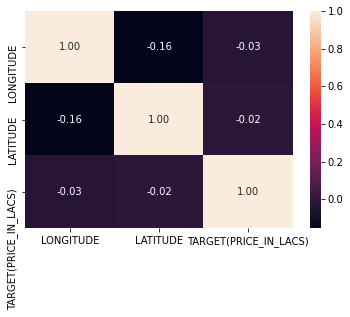

In [ ]:
import seaborn as sns
sns.heatmap(train[features].corr(),annot=True,fmt=".2f")

In [ ]:
pip install plotly-express

In [ ]:
%matplotlib inline

In [ ]:
import plotly_express as px
px.scatter_mapbox(train, lat="LATITUDE", lon="LONGITUDE", zoom=15)
plt.savefig("map.jpg")

<Figure size 432x288 with 0 Axes>

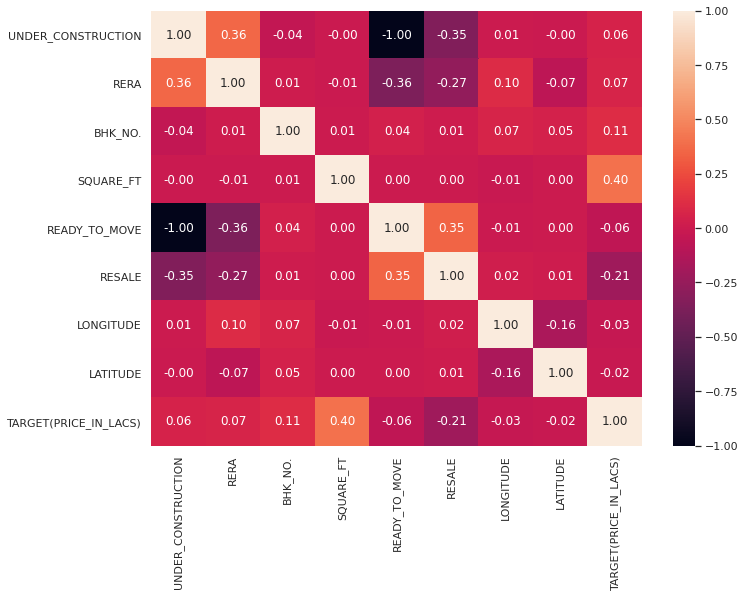

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize=(11,8))
sns.heatmap(train.corr(),annot=True,fmt=".2f")

In [7]:
cat_cols = [col for col in train.columns if train[col].dtypes == 'O']

In [8]:
cat_cols

['POSTED_BY', 'BHK_OR_RK', 'ADDRESS']

In [ ]:
for cols in cat_cols:
  print(train[cols].unique())

['Owner' 'Dealer' 'Builder']
['BHK' 'RK']
['Ksfc Layout,Bangalore' 'Vishweshwara Nagar,Mysore' 'Jigani,Bangalore'
 ... 'west mambalam,Chennai' 'Gandhi Nagar,Gulbarga'
 'E3-108, Lake View Recidency,,Vapi']


In [ ]:
train['BHK_NO.'].value_counts(normalize=True)

2     0.452412
3     0.358086
1     0.121354
4     0.058504
5     0.006451
6     0.001766
7     0.000374
8     0.000340
15    0.000136
10    0.000136
20    0.000136
12    0.000102
9     0.000102
13    0.000034
11    0.000034
17    0.000034
Name: BHK_NO., dtype: float64

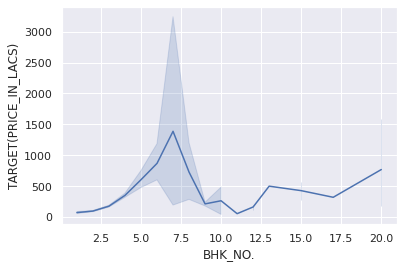

In [ ]:
sns.lineplot(x='BHK_NO.',y='TARGET(PRICE_IN_LACS)',data=train)

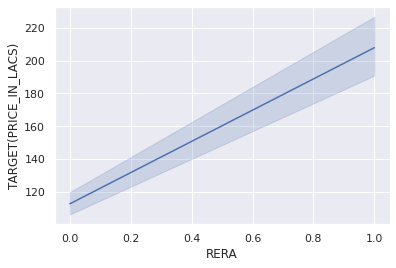

In [ ]:
sns.lineplot(x='RERA',y='TARGET(PRICE_IN_LACS)',data=train)

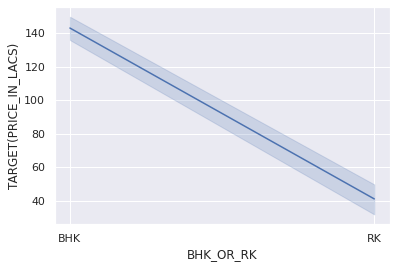

In [ ]:
sns.lineplot(x='BHK_OR_RK',y='TARGET(PRICE_IN_LACS)',data=train)

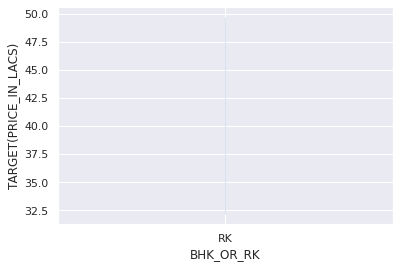

In [ ]:
sns.lineplot(x='BHK_OR_RK',y='TARGET(PRICE_IN_LACS)',data=train[train['BHK_OR_RK']=='RK'])

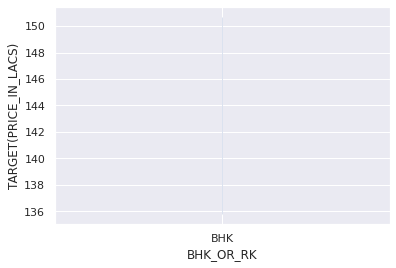

In [ ]:
sns.lineplot(x='BHK_OR_RK',y='TARGET(PRICE_IN_LACS)',data=train[train['BHK_OR_RK']=='BHK'])

In [9]:
pd.crosstab(train['BHK_OR_RK'],train['TARGET(PRICE_IN_LACS)'])

TARGET(PRICE_IN_LACS),0.25,0.29,0.48,0.85,1.00,1.30,1.50,2.00,3.40,3.50,3.90,4.00,4.50,4.90,5.00,5.20,5.50,5.70,6.00,6.50,7.00,7.10,7.20,7.30,7.40,7.50,7.60,7.80,7.90,8.00,8.10,8.20,8.50,8.60,8.70,9.00,9.10,9.30,9.50,9.60,...,8920.00,9000.00,9010.00,9020.00,9110.00,9150.00,9160.00,9200.00,9240.00,9320.00,9370.00,9390.00,9400.00,9430.00,9440.00,9450.00,9460.00,9480.00,9500.00,9523.00,9530.00,9540.00,9560.00,9580.00,9590.00,9600.00,9620.00,9630.00,9640.00,9700.00,9760.00,9790.00,9800.00,9850.00,9900.00,9910.00,9990.00,25000.00,28000.00,30000.00
BHK_OR_RK,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BHK,1,1,1,1,1,1,1,2,1,2,1,3,3,3,6,1,1,1,4,5,6,1,3,1,1,9,1,2,4,17,1,2,13,1,4,17,1,2,9,1,...,1,3,2,2,1,4,1,8,1,1,1,1,1,1,1,2,1,1,2,1,1,2,1,1,1,3,2,3,1,3,2,1,1,1,1,1,1,1,1,1
RK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.pivot_table(train,'TARGET(PRICE_IN_LACS)', index=['RERA', 'SQUR_FT'],
                     columns=['BHK_OR_RK'])

In [10]:
owner_enc = pd.get_dummies(train['POSTED_BY'])

In [11]:
bhk_enc = pd.get_dummies(train['BHK_OR_RK'])

In [12]:
train = pd.concat([train,owner_enc,bhk_enc],axis=1)

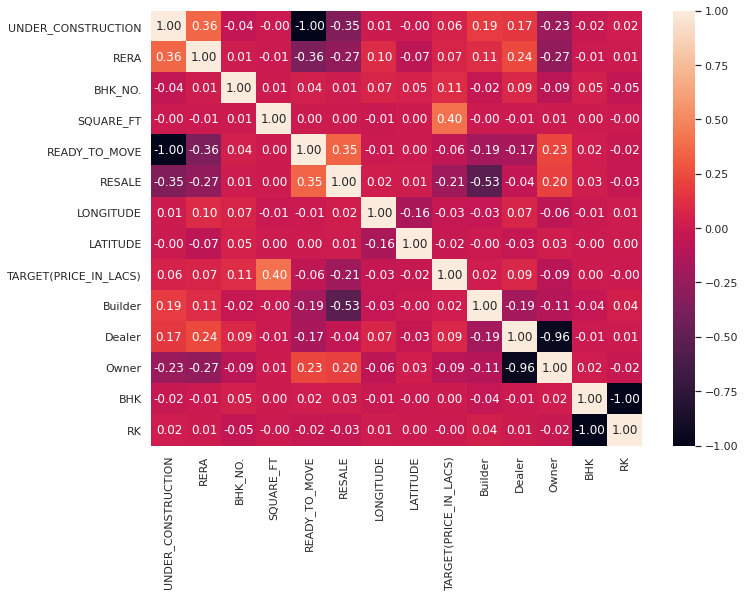

In [ ]:
plt.figure(figsize=(11,8))
sns.heatmap(train.corr(),annot=True,fmt=".2f")

In [13]:
train_new = train.drop(cat_cols,axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



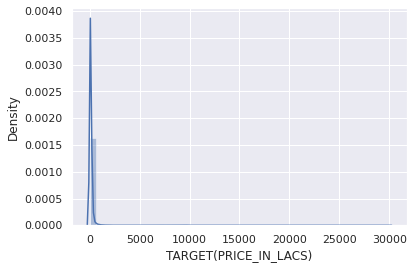

In [ ]:
sns.distplot(train_new['TARGET(PRICE_IN_LACS)'])

In [ ]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UNDER_CONSTRUCTION     29451 non-null  int64  
 1   RERA                   29451 non-null  int64  
 2   BHK_NO.                29451 non-null  int64  
 3   SQUARE_FT              29451 non-null  float64
 4   READY_TO_MOVE          29451 non-null  int64  
 5   RESALE                 29451 non-null  int64  
 6   LONGITUDE              29451 non-null  float64
 7   LATITUDE               29451 non-null  float64
 8   TARGET(PRICE_IN_LACS)  29451 non-null  float64
 9   Builder                29451 non-null  uint8  
 10  Dealer                 29451 non-null  uint8  
 11  Owner                  29451 non-null  uint8  
 12  BHK                    29451 non-null  uint8  
 13  RK                     29451 non-null  uint8  
dtypes: float64(4), int64(5), uint8(5)
memory usage: 2.2 MB

In [14]:
features = train_new.drop('TARGET(PRICE_IN_LACS)',axis=1).columns

In [15]:
target = 'TARGET(PRICE_IN_LACS)'

In [16]:
#defining metric

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse = make_scorer(RMSE, greater_is_better=False)

In [66]:
X = train[features]
Y = train[target]

#Hyperparameter tuning of extratrees Regressor using Bayesian optimization

In [ ]:
def etc_cv(n_estimators, min_samples_split, max_features, data, targets):
    estimator = ExtraTreesRegressor(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2,
        n_jobs = -1
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [ ]:
def optimize_etc(data, targets):
    def etc_crossval(n_estimators, min_samples_split, max_features):
        return etc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=etc_crossval,
        pbounds={
            "n_estimators": (100, 400),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)

    print("Final result:", optimizer.max)

In [ ]:

print(Colours.yellow("--- Optimizing Extra Trees ---"))
optimize_etc(X, Y)

--- Optimizing Extra Trees ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -206.6    |  0.2722   |  16.31    |  231.3    |
|  2        | -159.7    |  0.806    |  19.94    |  181.8    |
|  3        | -199.7    |  0.3485   |  20.44    |  387.4    |
|  4        | -151.3    |  0.8875   |  10.23    |  250.3    |
|  5        | -166.4    |  0.7144   |  18.39    |  211.1    |
|  6        | -166.9    |  0.6045   |  13.57    |  104.1    |
|  7        | -160.4    |  0.7948   |  22.3     |  209.5    |
|  8        | -162.1    |  0.6532   |  3.734    |  210.6    |
|  9        | -153.2    |  0.9389   |  16.98    |  219.2    |
|  10       | -156.0    |  0.8091   |  9.287    |  270.4    |
|  11       | -151.2    |  0.8912   |  9.964    |  250.2    |
|  12       | -150.4    |  0.9361   |  9.949    |  250.5    |
|  13       | -173.3    |  0.4865   |  9.667    |  250.8    |
|  14       | -157.4    |  0.8968   |  

In [18]:
etc = ExtraTreesRegressor(n_estimators=int(250.4962645661292),
                         min_samples_split=int(9.94925097176899),
                         max_features=0.9361287564089558,
                         n_jobs = -1,
                         random_state = 42)

#Hyperparameter tuning of RandomForest Regressor using Bayesian optimization

In [ ]:
def rfc_cv(n_estimators, min_samples_split, max_features, data, targets):
    estimator = RandomForestRegressor(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2,
        n_jobs = -1
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [ ]:
def optimize_rfc(data, targets):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (100, 450),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)

    print("Final result:", optimizer.max)

In [ ]:

print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(X,Y)

--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -250.4    |  0.2722   |  16.31    |  253.2    |
|  2        | -221.9    |  0.806    |  19.94    |  195.4    |
|  3        | -238.0    |  0.3485   |  20.44    |  435.3    |
|  4        | -214.2    |  0.8875   |  10.23    |  275.3    |
|  5        | -226.9    |  0.7144   |  18.39    |  229.6    |
|  6        | -226.1    |  0.6045   |  13.57    |  104.8    |
|  7        | -222.6    |  0.7948   |  22.3     |  227.7    |
|  8        | -209.1    |  0.6532   |  3.734    |  229.1    |
|  9        | -221.3    |  0.9389   |  16.98    |  239.0    |
|  10       | -213.7    |  0.8091   |  9.287    |  298.8    |
|  11       | -220.1    |  0.8021   |  18.14    |  421.8    |
|  12       | -220.7    |  0.9241   |  16.19    |  202.2    |
|  13       | -221.4    |  0.8985   |  23.55    |  192.6    |
|  14       | -227.4    |  0.3412   |

In [19]:
rfc = RandomForestRegressor(n_estimators = int(375.8035389777535),
                           min_samples_split=int(5.593308599448148),
                           max_features = 0.7954899986214853,
                           n_jobs = -1, 
                           random_state = 42)

#Hyperparameter tuning of LightGBM Regressor using Bayesian optimization

In [ ]:
def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, data, targets):
    estimator = LGBMRegressor(
        n_estimators=n_estimators,
        num_leaves = num_leaves,
        min_child_samples=min_child_samples,
        subsample = subsample,
        random_state = 2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [ ]:
def optimize_lgb(data, targets):
    def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample):
        return lgb_cv(
            n_estimators=int(n_estimators),
            num_leaves = int(num_leaves),
            min_child_samples=int(min_child_samples),
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=lgb_crossval,
        pbounds={
            "n_estimators": (200,500),
            "num_leaves": (30,80),
            "min_child_samples": (5,30),
            "subsample": (0.6,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)

In [ ]:
print(Colours.blue("--- Optimizing Light GBM ---"))
optimize_lgb(X,Y)

--- Optimizing Light GBM ---
|   iter    |  target   | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        | -312.3    |  9.788    |  386.6    |  51.89    |  0.9141   |
|  2        | -287.4    |  24.5     |  281.8    |  43.82    |  0.9207   |
|  3        | -300.4    |  28.95    |  462.8    |  47.89    |  0.8004   |
|  4        | -300.2    |  22.09    |  413.8    |  48.51    |  0.8245   |
|  5        | -284.5    |  17.58    |  204.1    |  68.64    |  0.9531   |
|  6        | -292.1    |  14.12    |  384.6    |  33.77    |  0.7475   |
|  7        | -295.7    |  28.33    |  395.4    |  49.86    |  0.9155   |
|  8        | -302.9    |  12.92    |  370.4    |  73.46    |  0.7745   |
|  9        | -285.3    |  25.05    |  243.1    |  65.21    |  0.8818   |
|  10       | -311.5    |  10.47    |  477.5    |  52.11    |  0.9637   |
|  11       | -319.6    |  6.495    |  255.3    |  32.37    |  0.87     |
|  12    

In [ ]:
np.sqrt(len(features))

3.605551275463989

In [28]:
lgb = LGBMRegressor(
        n_estimators=int(203.94506329369526),
        num_leaves = int(69.4967773968443),
        min_child_samples=int(17.097640410918434),
        subsample =  0.6017035953446536,
        random_state = 42
    )


#Hyperparameter tuning of XGBoost Regressor using Bayesian optimization

In [29]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [30]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (200, 500),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)

In [31]:
print(Colours.red("--- Optimizing XGBoost ---"))
optimize_xgb(X,Y)

--- Optimizing XGBoost ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
[12:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:47:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  1        | -269.7    |  1.915    |  11.6     |  4.377    |  435.6    |  0.956    |
[12:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear i

In [32]:

xgb = XGBRegressor(
        n_estimators=int(402.62301199186254),
        max_depth = int(7.717585482730352),
        gamma = 0.6604220629070646,
        min_child_weight=0.5628674807074144,
        subsample =0.9138065740563963,
        random_state = 42,
    )

#Hyperparameter tuning of Catboost Regressor using Bayesian optimization

In [ ]:
def cb_cv(n_estimators, depth,data, targets):
    estimator = CatBoostRegressor(
        n_estimators=n_estimators,
#         learning_rate=learning_rate,
        depth=depth,
        random_state = 2,
        verbose = 0,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [ ]:
def optimize_cb(data, targets):
    def cb_crossval(n_estimators, depth):
        return cb_cv(
            n_estimators=int(n_estimators),
#             learning_rate = learning_rate,
            depth = int(depth),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=cb_crossval,
        pbounds={
            "n_estimators": (200, 600),
#             "learning_rate": (0.01,10),
            "depth": (4,16),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)


In [ ]:
train_new.columns

Index(['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'SQUARE_FT', 'READY_TO_MOVE',
       'RESALE', 'LONGITUDE', 'LATITUDE', 'TARGET(PRICE_IN_LACS)', 'Builder',
       'Dealer', 'Owner', 'BHK', 'RK'],
      dtype='object')

In [ ]:
features

Index(['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'SQUARE_FT', 'READY_TO_MOVE',
       'RESALE', 'LONGITUDE', 'LATITUDE', 'Builder', 'Dealer', 'Owner', 'BHK',
       'RK'],
      dtype='object')

In [ ]:
X = train_new[features]
Y = train[target]
print(Colours.bold("--- Optimizing Catboost ---"))
optimize_cb(X,Y)

--- Optimizing Catboost ---
|   iter    |  target   |   depth   | n_esti... |
-------------------------------------------------
|  1        | -299.7    |  6.298    |  448.8    |
|  2        | -307.7    |  9.253    |  514.1    |
|  3        | -306.2    |  13.36    |  309.0    |
|  4        | -301.6    |  7.318    |  520.7    |
|  5        | -290.9    |  15.5     |  550.4    |
|  6        | -296.2    |  8.294    |  400.4    |
|  7        | -301.5    |  12.2     |  485.1    |
|  8        | -289.1    |  8.443    |  424.5    |
|  9        | -294.6    |  10.04    |  205.5    |
|  10       | -299.1    |  13.27    |  553.1    |
|  11       | -299.1    |  8.379    |  446.2    |
|  12       | -284.9    |  4.905    |  347.5    |
|  13       | -300.2    |  15.2     |  460.6    |
|  14       | -300.7    |  8.766    |  515.5    |
|  15       | -306.4    |  7.802    |  427.2    |
|  16       | -306.6    |  14.43    |  374.5    |
|  17       | -294.7    |  13.63    |  257.5    |
|  18       | -300.8  

In [21]:
cb = CatBoostRegressor(n_estimators=347.5296024007898,
                      depth = 4.904574899715719,
                      verbose = 0,
                      random_state = 42)

#Hyperparameter tuning of XGBoost RandomForest Regressor using Bayesian optimization

In [22]:

def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRFRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [23]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (200, 500),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)

In [24]:
print(Colours.red("--- Optimizing XGBoost RandomForest ---"))
optimize_xgb(X,Y)

--- Optimizing XGBoost RandomForest ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
[11:52:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:53:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:53:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:53:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
|  1        | -267.6    |  1.915    |  11.6     |  4.377    |  435.6    |  0.956    |
[11:53:58] WARNING: /workspace/src/objective/regression_obj.cu:152:

In [25]:
xgbrf = XGBRFRegressor(
        n_estimators=int(311.18895799284957),
        max_depth = int(11.520264838187105),
        gamma = 2.930052221096433,
        min_child_weight=0.0,
        subsample = 0.9831854660202296,
        random_state = 42,
    )

#Stacking least correlated models

In [33]:

estimators = [('etc', etc), ('rfc', rfc), ('xgb', xgb), ('lgb', lgb), ('xgbrf', xgbrf)]

model = StackingRegressor(estimators=estimators)

# Train the model


In [34]:
model.fit(X,Y)

[13:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

StackingRegressor(cv=None,
                  estimators=[('etc',
                               ExtraTreesRegressor(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=0.9361287564089558,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=9,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators

In [53]:
x_coord = X[['LONGITUDE','LATITUDE']]

In [54]:
from sklearn.cluster import KMeans
K = range(1,10) 
inertias = []
inertias_map = {}
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(x_coord)     
    inertias_map[k] = kmeanModel.inertia_
    inertias.append(kmeanModel.inertia_)

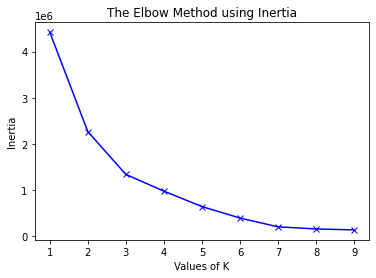

In [55]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [56]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(x_coord) 
labels =  kmeanModel.predict(x_coord)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


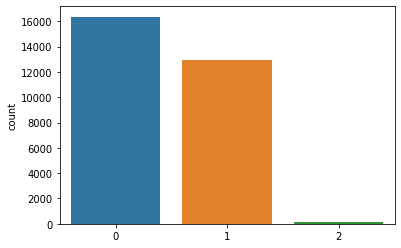

In [57]:
sns.countplot(labels)

In [58]:
x_coord ["GROUP"] = labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
x_coord.head()

,LONGITUDE,LATITUDE,GROUP
0,12.969910,77.597960,0
1,12.274538,76.644605,0
2,12.778033,77.632191,0
3,28.642300,77.344500,1
4,22.592200,88.484911,1


In [67]:
len(labels),x_coord.shape

(29451, (29451, 3))

In [68]:
X["GROUP"] = labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
X.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,Builder,Dealer,Owner,BHK,RK,GROUP
0,0,0,2,1300.236407,1,1,12.969910,77.597960,0,0,1,1,0,0
1,0,0,2,1275.000000,1,1,12.274538,76.644605,0,1,0,1,0,0
2,0,0,2,933.159722,1,1,12.778033,77.632191,0,0,1,1,0,0
3,0,1,2,929.921143,1,1,28.642300,77.344500,0,0,1,1,0,1
4,1,0,2,999.009247,0,1,22.592200,88.484911,0,1,0,1,0,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


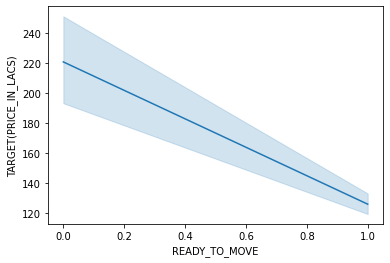

In [87]:
sns.lineplot(X["READY_TO_MOVE"],Y)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


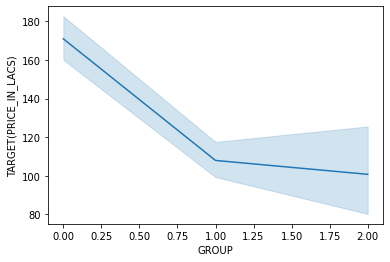

In [75]:
sns.lineplot(X["GROUP"],Y)

In [76]:
train["GROUP"] = labels

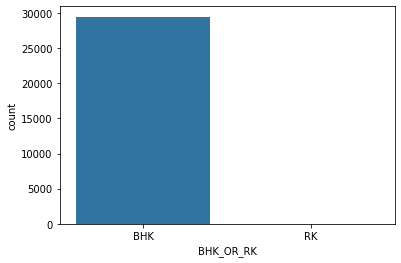

In [79]:
sns.countplot(x="BHK_OR_RK",data=train)

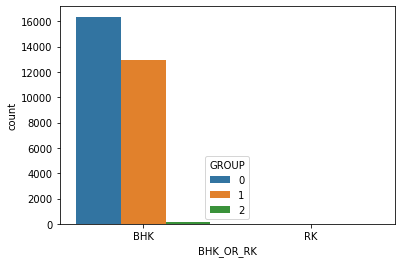

In [78]:
sns.countplot(x="BHK_OR_RK",data=train,hue="GROUP")

In [70]:
X.isnull().sum()

UNDER_CONSTRUCTION    0
RERA                  0
BHK_NO.               0
SQUARE_FT             0
READY_TO_MOVE         0
RESALE                0
LONGITUDE             0
LATITUDE              0
Builder               0
Dealer                0
Owner                 0
BHK                   0
RK                    0
GROUP                 0
dtype: int64

In [64]:
X.shape,Y.shape

((3270011, 14), (29451,))

In [71]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.20,random_state=42)

In [72]:
model.fit(X_train,y_train)

[14:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

StackingRegressor(cv=None,
                  estimators=[('etc',
                               ExtraTreesRegressor(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=0.9361287564089558,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=9,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators

In [73]:
y_pred = model.predict(X_test)

# RMSE score

In [52]:
RMSE(y_test, y_pred)

331.3414666265043

After adding *group*

In [74]:
RMSE(y_test, y_pred)

331.3999921635641

#Predicting


Test Data PreProcessing

In [35]:
test.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE
0,Owner,0,0,1,BHK,545.171340,1,1,"Kamrej,Surat",21.262000,73.047700
1,Dealer,1,1,2,BHK,800.000000,0,0,"Panvel,Lalitpur",18.966114,73.148278
2,Dealer,0,0,2,BHK,1257.096513,1,1,"New Town,Kolkata",22.592200,88.484911
3,Dealer,0,0,3,BHK,1400.329489,1,1,"Kalwar Road,Jaipur",26.988300,75.584600
4,Owner,0,0,1,BHK,430.477830,1,1,"Mai Mandir,Nadiad",22.700000,72.870000


In [36]:
bhk_enc_test = pd.get_dummies(test['BHK_OR_RK'])
owner_enc_test = pd.get_dummies(test['POSTED_BY'])
test = pd.concat([test,owner_enc_test,bhk_enc_test],axis=1)

In [80]:
test_coord = test[["LATITUDE","LONGITUDE"]]

In [81]:
label_test  = kmeanModel.predict(test_coord)

In [82]:
test["GROUP"] = label_test

In [83]:
test_new = test[X.columns.tolist()]

In [84]:
test_new.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,Builder,Dealer,Owner,BHK,RK,GROUP
0,0,0,1,545.171340,1,1,21.262000,73.047700,0,0,1,1,0,2
1,1,1,2,800.000000,0,0,18.966114,73.148278,0,1,0,1,0,2
2,0,0,2,1257.096513,1,1,22.592200,88.484911,0,1,0,1,0,2
3,0,0,3,1400.329489,1,1,26.988300,75.584600,0,1,0,1,0,1
4,0,0,1,430.477830,1,1,22.700000,72.870000,0,0,1,1,0,2


In [85]:

preds = model.predict(test_new)

In [40]:
sub = pd.read_csv("/content/Participants_Data_HPP/sample_submission.csv")

In [41]:
sub.head()

,TARGET(PRICE_IN_LACS)
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [43]:
sub['TARGET(PRICE_IN_LACS)'] = preds

In [44]:
sub.head()

,TARGET(PRICE_IN_LACS)
0,30.034004
1,79.431009
2,61.529254
3,38.789242
4,11.828358


In [45]:
test.shape,sub.shape

((68720, 16), (68720, 1))

In [46]:
sub.to_csv('MH_Hosuing_price.csv',index=False)

In [86]:

preds1 = model.predict(test_new)
sub['TARGET(PRICE_IN_LACS)'] = preds1
sub.to_csv('MH_Hosuing_price1.csv',index=False)